In [1]:
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib import pyplot as plt
import torch
import torchvision
from torch import nn, optim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.io import loadmat
import os, sys
import torchvision.transforms as transforms
import string
from  collections import defaultdict
from sklearn.linear_model import LassoCV

# images = loadmat('baoimg.mat').get('img')
%run clean_cornets.py

In [2]:
from torchvision import datasets, transforms

# data_dir = 'images/'
data_dir = 'stimuli/jumbledWords/'
transform = {'train': transforms.Compose([transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),}

chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform =  transform[x]) for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size = 80,shuffle = False) for x in ['train']}



In [ ]:
# Visualizing few images. 
xx = iter(dataloaders['train'])
images, labels = next(xx)
grid = torchvision.utils.make_grid(images[:24,:,:,:]);
plt.figure(figsize = (10,100));
plt.imshow(grid.numpy().transpose((1, 2, 0)));

In [13]:
dataiter = iter(dataloaders['train'])

# nBli = {}; nBli['it'] = []; nBli['h'] = []; nBli['out'] = []
# net = CORNet_Z_nonbiased_words()
# checkpoint = torch.load('models/save_lit_no_bias_z_79_full_nomir.pth.tar')['state_dict']
# for key in list(checkpoint.keys()):
#     if 'module.' in key:
#         checkpoint[key.replace('module.', '')] = checkpoint[key]
#         del checkpoint[key]
# net.load_state_dict(checkpoint)
# # net.eval() 
    
# for i in range(35):
#     stimtemp, classes = next(dataiter)
#     # nBli['v1'], nBli['v2'], nBli['v4'], nBli['it'], nBli['h'],  nBli['out'] = net(stimtemp.float())
#     _,_,_,varIt,varh, varOut = net(stimtemp.float())
#     nBli['it'].extend(varIt.detach().numpy()); 
#     nBli['h'].extend(varh.detach().numpy()); 
#     nBli['out'].extend(varOut.detach().numpy()); 
#     print(i)

###  Biased literate network
Bli = {}; Bli['it'] = []; Bli['h'] = []; Bli['out'] = []
net = CORNet_Z_biased_words()
checkpoint = torch.load('models/save_lit_bias_z_79_full_nomir.pth.tar')['state_dict']
for key in list(checkpoint.keys()):
    if 'module.' in key:
        checkpoint[key.replace('module.', '')] = checkpoint[key]
        del checkpoint[key]
net.load_state_dict(checkpoint)
    
for i in range(100):
    stimtemp, classes = next(dataiter)
    _,_,_,varIt,varh, varOut = net(stimtemp.float())
    Bli['it'].extend(varIt.detach().numpy())
    Bli['h'].extend(varh.detach().numpy())
    Bli['out'].extend(varOut.detach().numpy())
    print(i)

## Loading all the three network and extracting representation from all the hidden units
# ili = {}; ili['it'] = []; ili['h'] = []; ili['out'] = []
# net = CORnet_Z_tweak()
# checkpoint = torch.load('models/save_illit_z_79_full_nomir.pth.tar')['state_dict']
# # checkpoint = torch.load('models/save_pre_z_49_full_nomir.pth.tar')['state_dict']

# for key in list(checkpoint.keys()):
#     if 'module.' in key:
#         checkpoint[key.replace('module.', '')] = checkpoint[key]
#         del checkpoint[key]
# net.load_state_dict(checkpoint)

# for i in range(35):
#     stimtemp, classes = next(dataiter)
#     _,_,_,varIt,varh, varOut = net(stimtemp.float())
#     ili['it'].extend(varIt.detach().numpy())
#     ili['h'].extend(varh.detach().numpy())
#     ili['out'].extend(varOut.detach().numpy())
#     print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


StopIteration: 

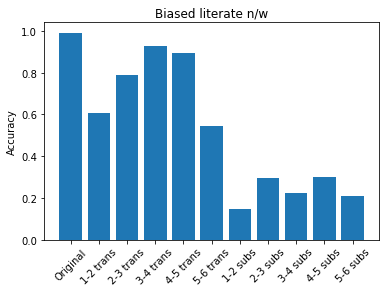

In [15]:
gnet = {}; gnet['it'] = []; gnet['h'] = []; gnet['out'] = []
gnet['it'] = np.array(Bli['it'])
gnet['h'] = np.array(Bli['h'])
gnet['out'] = np.array(Bli['out'])

classid = []
for i in range(np.size(gnet['out'],0)):
    classid.append(np.argmax((gnet['out'][i,:])))
classid = np.reshape(classid,[11,248])

words = np.load('sorted_wordlist.npy')
wordlen = [len(x) for x in words]
true_label = np.array(np.where(np.array(wordlen) ==6))+1000


acc = []
for i in range(11):
#     acc.append(np.sum(classid[i,:] == classid[0,:])/248)
    acc.append(np.sum(classid[i,:] == true_label)/248)

plt.bar(range(11),acc)
legend = ['Original','1-2 trans','2-3 trans','3-4 trans','4-5 trans','5-6 trans',
          '1-2 subs','2-3 subs','3-4 subs','4-5 subs','5-6 subs',]
plt.ylabel('Accuracy'); plt.title('Biased literate n/w')
plt.xticks(range(11), labels = legend ,rotation= 45);

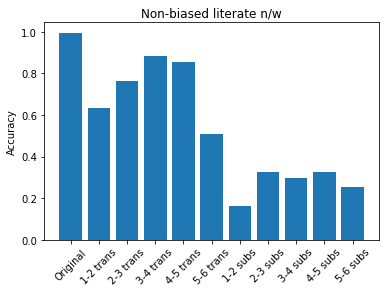

In [14]:
plt.bar(range(11),acc)
legend = ['Original','1-2 trans','2-3 trans','3-4 trans','4-5 trans','5-6 trans',
          '1-2 subs','2-3 subs','3-4 subs','4-5 subs','5-6 subs',]
plt.ylabel('Accuracy'); plt.title('Non-biased literate n/w')
plt.xticks(range(11), labels = legend ,rotation= 45);

Text(0.5, 1.0, 'IT layer - illiterate n/w')

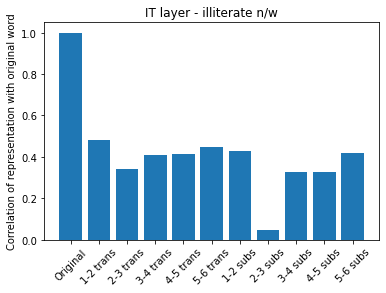

In [10]:
# Comparing representation space. 
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from scipy.special import comb


distMetric = 'euclidean'

D = np.zeros((comb(248, 2,exact =True),11)); 

for i in range(11):
    idx = np.arange(248*(i-1), 248*i)
    D[:,i] = squareform(pairwise_distances(gnet['it'][idx,:],metric = distMetric))
    
rval = []
for i in range(11):
    r,_ = scipy.stats.spearmanr(D[:,0],D[:,i])
    rval.append(r)
    
plt.bar(range(11),rval)
plt.ylabel('Correlation of representation with original word');
plt.xticks(range(11), labels = legend,rotation= 45);
plt.title('IT layer - illiterate n/w')